# FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
## Test problem is chosen to give an exact solution at all nodes of the mesh.

## Governing Equation:

$-\Delta u = f$   

## Domain:

$([0,1] \times [0,1]) \times ([0,1] \times [0,1]) $

## Exact solution:

$u_{exact} = 1 + x^2 + 2y^2 + 3z^2 + 4w^2$

## Boundary condition:

$u = u_{exact} $ on the boundary

## Forcing term:

f = -20

In [1]:
#Import modules
from __future__ import print_function
import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Can not Run Poisson Problem Standard way (no Cartesian Product)


#  but can now using Cartesian Product

## Domain is product of 2 square meshes


In [2]:
#Some auxillary functions defined first
def cartesian_product(array1,array2):
    #gives cartesian product of 2 vectors
    dim1,n=array1.shape
    dim2,n=array2.shape
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr
def cartesian_product_coords(array1,array2):
    #gives cartesian product of 2 vectors
    dim1,n1=array1.shape
    dim2,n2=array2.shape
    out_arr=np.zeros((dim1*dim2,n1+n2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            #print(array1[a,:])
            #print(array2[b,:])
            out_arr[c,:]=np.append(array1[a,:],array2[b,:])
            c=c+1
    return out_arr
def cartesian_product_dofs(array1,array2):
    #gives cartesian product of 2 1d vectors
    dim1=len(array1)
    dim2=len(array2)
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr


def cartesian_form_to_kroneck_form(indeces, len_dim_2):
    #designed to take list of indexes in the cartesian form
    #translate to single form as kron product would
    #only for cartesian product between 2 spaces
    #expects matrix with n rows, 2 columns
    num_indeces=indeces.shape[0]
    out_arr=np.zeros(num_indeces)
    for n in range(num_indeces):
        out_arr[n] = indeces[n,0]*len_dim_2 + indeces[n,1]
    return out_arr

In [3]:
#cartesian product of 2 1-d domains with dirichlet boundary
mesh1 = dl.UnitSquareMesh(4,4)
mesh2 = dl.UnitSquareMesh(4,4)

#create function spaces for each piece
V1 = dl.FunctionSpace(mesh1, 'P', 1)
V2 = dl.FunctionSpace(mesh2, 'P', 1)

#create trial and test functions
u1_trial = dl.TrialFunction(V1)
v1_test = dl.TestFunction(V1)
u2_trial = dl.TrialFunction(V2)
v2_test = dl.TestFunction(V2)

#assemble weak forms (more complex due to chain rule)
stiffness_form11 = dl.inner(dl.grad(u1_trial), dl.grad(v1_test)) * dl.dx
stiffness_form12 = u1_trial*v1_test* dl.dx

stiffness_form21 = dl.inner(dl.grad(u2_trial), dl.grad(v2_test)) * dl.dx
stiffness_form22 = u2_trial*v2_test * dl.dx

#assign right hand side (will need to generalize later)
f = dl.Constant(-20.0)


#assemble stiffness matrices (only will work for linear forms)
K11 = dl.assemble(stiffness_form11)
K12 = dl.assemble(stiffness_form12)
K21 = dl.assemble(stiffness_form21) 
K22 = dl.assemble(stiffness_form22)


#assign right hand sides 
rhs_form1 = v1_test * dl.dx
rhs_form2 = f * v2_test * dl.dx
b1 = dl.assemble(rhs_form1)
b2 = dl.assemble(rhs_form2)

#use this to mark boundary (Dirichlet) 
def boundary(x, on_boundary):
    return on_boundary

#This function is simply used to mark the boundary (not the actual boundary condition)
u_D1 = dl.Expression('1.0', degree=2)


#establish dummy functions
dum1=dl.Function(V1)
dum2=dl.Function(V2)


#create boundary conditions
bc1 = dl.DirichletBC(V1, u_D1, boundary)
bc2 = dl.DirichletBC(V2, u_D1, boundary)

#apply to vectors to mark boundaries
bc1.apply(dum1.vector())
bc2.apply(dum2.vector())

#get index number for each boundary cooordinates in subdomain
boundary_dofs1 = np.where(dum1.vector()==1.0)[0]
boundary_dofs2 = np.where(dum2.vector()==1.0)[0]

#print indeces of boundaries in subdomains
print(boundary_dofs1)
print(boundary_dofs2)

#need all physical coordinates in case we need for calculations
dof_coordinates1=V1.tabulate_dof_coordinates()
dof_coordinates2=V1.tabulate_dof_coordinates()

#physical coordinates should be just cartesian product of 2 dof maps in same order that kron product operates
global_dof=cartesian_product_coords(dof_coordinates1,dof_coordinates2)

#coordinates of boundary in each subdomain
boundary_coord1 = dof_coordinates1[boundary_dofs1]
boundary_coord2 = dof_coordinates2[boundary_dofs2]


#now connect subdomain indeces to global boundary (turn this into function in future)
#maybe in future for speed we can precompute number of boundary dofs
global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2) + len(dof_coordinates1)*len(boundary_dofs2),2))

ctr=0
for j in boundary_dofs1:
    global_boundary_dofs[ctr*len(dof_coordinates2):(ctr+1)*len(dof_coordinates2),:] = \
    cartesian_product_dofs(np.array([j]),np.arange(dof_coordinates2.shape[0]))
    ctr=ctr+1
    
last_ind = (ctr)*len(dof_coordinates2)


for j in boundary_dofs2:
    global_boundary_dofs[last_ind:last_ind+len(dof_coordinates2),:] = \
    cartesian_product_dofs(np.arange(dof_coordinates1.shape[0]),np.array([j]))
    last_ind = last_ind+len(dof_coordinates2)    


#sorts and also eliminates duplicates of "corners"
global_boundary_dofs=np.unique(global_boundary_dofs,axis=0)


#have cartesian product of dof at entire boundary (this form should be easy to get coordinates in if needed)
#now need to convert to global system dof as the kron function does
global_boundary_dofs=cartesian_form_to_kroneck_form(global_boundary_dofs, len(dof_coordinates2))
global_boundary_dofs=global_boundary_dofs.astype(int)




#assemble global system using kronecker product
K11 = np.array(K11.array())
K12 = np.array(K12.array())
K21 = np.array(K21.array())
K22 = np.array(K22.array())

A=np.kron(K11,K22) + np.kron(K12,K21)




b1 = np.array(b1)
b2 = np.array(b2)
B=np.kron(b1,b2)

#need to apply bcs using boundary_dofs info
#set the rows in the boundary to 1 on diagonal
K_bound = np.zeros(A.shape)
for i in global_boundary_dofs:
    K_bound[i,i] = 1

A[global_boundary_dofs,:] = K_bound[global_boundary_dofs,:]


#set the value of solution on boundary as rhs
B[global_boundary_dofs] = 1+ global_dof[global_boundary_dofs,0]**2 + 2*global_dof[global_boundary_dofs,1]**2 \
+ 3*global_dof[global_boundary_dofs,2]**2 + 4*global_dof[global_boundary_dofs,3]**2

#solve global system
u=np.zeros(len(B))

#solve(A,u,B)
u=np.linalg.solve(A,B)



[ 0  1  2  3  5  6  9 10 14 15 18 19 21 22 23 24]
[ 0  1  2  3  5  6  9 10 14 15 18 19 21 22 23 24]


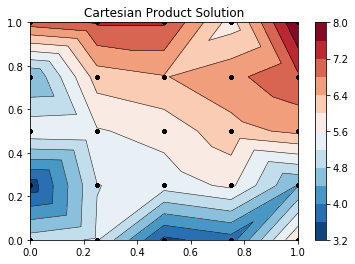

[  7.       5.25     7.1875   4.       5.4375   7.75     3.25     4.1875
   6.       8.6875   3.       3.4375   4.75     6.9375  10.       3.1875
   4.       5.6875   8.25     3.75     4.9375   7.       4.6875   6.25     6.
   6.125    4.375    6.3125   3.125    4.5625   6.875    2.375    3.3125
   5.125    7.8125   2.125    2.5625   3.875    6.0625   9.125    2.3125
   3.125    4.8125   7.375    2.875    4.0625   6.125    3.8125   5.375
   5.125    7.0625   5.3125   7.25     4.0625   5.5      7.8125   3.3125
   4.25     6.0625   8.75     3.0625   3.5      4.8125   7.      10.0625
   3.25     4.0625   5.75     8.3125   3.8125   5.       7.0625   4.75
   6.3125   6.0625   5.5      3.75     5.6875   2.5      3.9375   6.25
   1.75     2.6875   4.5      7.1875   1.5      1.9375   3.25     5.4375
   8.5      1.6875   2.5      4.1875   6.75     2.25     3.4375   5.5
   3.1875   4.75     4.5      6.1875   4.4375   6.375    3.1875   4.625
   6.9375   2.4375   3.375    5.1875   7.875    2.1875 

In [4]:
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)

ax2.tricontour(global_dof[:,0], global_dof[:,1], u, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Cartesian Product Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()

print(u)

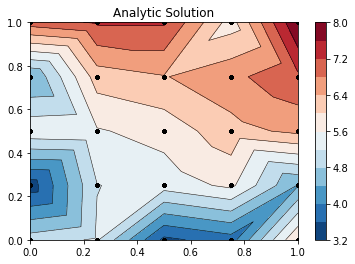

[  7.       5.25     7.1875   4.       5.4375   7.75     3.25     4.1875
   6.       8.6875   3.       3.4375   4.75     6.9375  10.       3.1875
   4.       5.6875   8.25     3.75     4.9375   7.       4.6875   6.25     6.
   6.125    4.375    6.3125   3.125    4.5625   6.875    2.375    3.3125
   5.125    7.8125   2.125    2.5625   3.875    6.0625   9.125    2.3125
   3.125    4.8125   7.375    2.875    4.0625   6.125    3.8125   5.375
   5.125    7.0625   5.3125   7.25     4.0625   5.5      7.8125   3.3125
   4.25     6.0625   8.75     3.0625   3.5      4.8125   7.      10.0625
   3.25     4.0625   5.75     8.3125   3.8125   5.       7.0625   4.75
   6.3125   6.0625   5.5      3.75     5.6875   2.5      3.9375   6.25
   1.75     2.6875   4.5      7.1875   1.5      1.9375   3.25     5.4375
   8.5      1.6875   2.5      4.1875   6.75     2.25     3.4375   5.5
   3.1875   4.75     4.5      6.1875   4.4375   6.375    3.1875   4.625
   6.9375   2.4375   3.375    5.1875   7.875    2.1875 

In [5]:
#plot analytic solution
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)

u_true = 1 + global_dof[:,0]**2 + 2*global_dof[:,1]**2 + 3*global_dof[:,2]**2 + 4*global_dof[:,3]**2

ax2.tricontour(global_dof[:,0], global_dof[:,1], u_true, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u_true, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Analytic Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()
print(u_true)

In [6]:
print(u-u_true)

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00